In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os.path
sys.path.append('..')  # import bread
sys.path.append(os.path.abspath('../lib'))
import bread.data, bread.data.graph, bread.data.segmentation, bread.algo.tracking.gnn as bread_nn
from bread.algo.tracking.gnn import GNNNodeClassifier1
import torch
from glob import glob
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import itertools

In [3]:
imgs_seg = bread.data.load_npz(sorted(glob('../data/segmentations/colony007/*.npz')))
imgs_vis = bread.data.load_npz(sorted(glob('../data/microscopy_PhC/colony007/*.npz')))

# Accuracy metric

In [4]:
accuracy = bread.algo.tracking.accuracy

# Testing interframes

In [5]:
max_dt = 5
interframes = [(idt, idt+dt) for idt, dt in itertools.product(range(len(imgs_seg)), range(1, max_dt+1)) if idt+dt < len(imgs_seg)]

In [6]:
interframes[-10:]

[(175, 176),
 (175, 177),
 (175, 178),
 (175, 179),
 (176, 177),
 (176, 178),
 (176, 179),
 (177, 178),
 (177, 179),
 (178, 179)]

In [7]:
len(interframes)

885

# GNN accuracy

In [8]:
model = GNNNodeClassifier1.load_from_checkpoint('model_weights/best/epoch=43-step=12055.ckpt')
model.eval()  # set to evaluation mode

GNNNodeClassifier1(
  (loss): CrossEntropyLoss()
  (node_encoder): MLP(6, 120, 120, 120, 120, 120)
  (edge_encoder): MLP(6, 120, 120, 120, 120, 120)
  (layers): ModuleList(
    (0): DeepGCNLayer(block=res+)
    (1): DeepGCNLayer(block=res+)
    (2): DeepGCNLayer(block=res+)
    (3): DeepGCNLayer(block=res+)
    (4): DeepGCNLayer(block=res+)
    (5): DeepGCNLayer(block=res+)
    (6): DeepGCNLayer(block=res+)
    (7): DeepGCNLayer(block=res+)
    (8): DeepGCNLayer(block=res+)
    (9): DeepGCNLayer(block=res+)
    (10): DeepGCNLayer(block=res+)
  )
  (lin): Linear(in_features=120, out_features=2, bias=True)
)

In [9]:
accs = np.zeros((len(interframes), 5))

for idx, (idt1, idt2) in tqdm(enumerate(interframes)):
	img_seg1, img_seg2 = imgs_seg[idt1], imgs_seg[idt2]
	
	graph1 = bread.data.graph.build_cellgraph(img_seg1, max_membdist=12)
	graph2 = bread.data.graph.build_cellgraph(img_seg2, max_membdist=12)
	assgraph = bread.data.graph.build_assignmentgraph(graph1, graph2)
	assgraph_truth = bread.data.graph.build_assignmentgraph_track(img_seg1, img_seg2)
	
	z = model(assgraph).detach().reshape(graph1.num_nodes, graph2.num_nodes, 2)
	# z = torch.nn.functional.softmax(z, dim=2)  # this litterally changes nothing
	y_hat = model.predict(assgraph)
	y = assgraph_truth.x.T.squeeze().type(torch.long)
	
	ass_true = y.reshape(graph1.num_nodes, graph2.num_nodes)
	ass_naive = y_hat.reshape(graph1.num_nodes, graph2.num_nodes)
	acc_naive = accuracy(ass_true, ass_naive)
	ass_fw = bread_nn.assmatrix_forward(z)
	acc_fw = accuracy(ass_true, ass_fw)
	ass_bw = bread_nn.assmatrix_backward(z)
	acc_bw = accuracy(ass_true, ass_bw)
	ass_bw_con = bread_nn.assmatrix_backward_constrained(z)
	acc_bw_con = accuracy(ass_true, ass_bw_con)
	ass_linsum = bread_nn.assmatrix_linear_sum(z)
	acc_linsum = accuracy(ass_true, ass_linsum)
	
	accs[idx, 0] = acc_naive
	accs[idx, 1] = acc_fw
	accs[idx, 2] = acc_bw
	accs[idx, 3] = acc_bw_con
	accs[idx, 4] = acc_linsum

0it [00:00, ?it/s]

# YeaZ accuracy

In [10]:
import YeaZ.unet.hungarian as YeaZ_hung
import scipy.spatial.distance

In [11]:
def match_cellids(seg1, seg2, eps=1e-6):
	# Matches cellids between two identical segmentations, which use different numberings
	cms1 = bread.utils.get_cms(seg1)
	cms2 = bread.utils.get_cms(seg2)
	
	dists = scipy.spatial.distance.cdist(cms1, cms2)
	matches = dists < eps
	idx1, idx2 = matches.nonzero()
	
	return idx2


def assmatrix_from_segmentations(seg1, seg2):
	cellids1 = bread.utils.get_cellids(seg1)
	cellids2 = bread.utils.get_cellids(seg2)
	
	ass = np.empty((len(cellids1), len(cellids2)), dtype=bool)
	
	for idx1, idx2 in itertools.product(range(len(cellids1)), range(len(cellids2))):
		ass[idx1, idx2] = cellids1[idx1] == cellids2[idx2]
		
	return ass

In [12]:
accs_yeaz = np.empty((len(interframes),))

for idx, (idt1, idt2) in tqdm(enumerate(interframes)):
	img_seg1, img_seg2 = imgs_seg[idt1], imgs_seg[idt2]
	img_seg2_hat = YeaZ_hung.correspondence(img_seg1, img_seg2)
	
	# idmap1 = match_cellids(img_seg1, img_seg_yeaz1)
	idmap2 = match_cellids(img_seg2, img_seg2_hat)

	ass = assmatrix_from_segmentations(img_seg1, img_seg2)
	ass_yeaz = assmatrix_from_segmentations(img_seg1, img_seg2)[:, idmap2]
	
	accs_yeaz[idx] = accuracy(ass_yeaz, ass)

0it [00:00, ?it/s]

In [13]:
# imgs_seg_yeaz = bread.data.segmentation.load_segmentations_yeaz('../data/segmentations_yeaz/colony007_yeazretrack.h5')[:-1]  # due to a bug in yeaz, the last frame is not saved correctly
# accs_yeaz = np.empty((len(interframes),))

# for idx, (idt1, idt2) in tqdm(enumerate(interframes)):
# 	img_seg_yeaz_1, img_seg_yeaz_2 = imgs_seg_yeaz[idt1], imgs_seg_yeaz[idt2]
# 	img_seg_1, img_seg_2 = imgs_seg[idt1], imgs_seg[idt2]
	
# 	idmap1 = match_cellids(img_seg_1, img_seg_yeaz_1)
# 	idmap2 = match_cellids(img_seg_2, img_seg_yeaz_2)

# 	ass = assmatrix_from_segmentations(img_seg_1, img_seg_2)
# 	ass_yeaz = assmatrix_from_segmentations(img_seg_yeaz_1, img_seg_yeaz_2)[idmap1, :][:, idmap2]
	
# 	accs_yeaz[idx] = accuracy(ass_yeaz, ass)

# Comparison

## Summmary

In [14]:
df = pd.DataFrame(np.hstack((accs, accs_yeaz[:, None])), columns=['naive', 'forward', 'backward', 'backward+corr', 'linsum', 'yeaz'])

In [15]:
df.describe()

,naive,forward,backward,backward+corr,linsum,yeaz
count,885.000000,885.000000,885.000000,885.000000,885.000000,885.000000
mean,0.986984,0.998341,0.986895,0.995342,0.999913,0.994201
std,0.043199,0.014823,0.040118,0.017675,0.000645,0.059083
min,0.777778,0.777778,0.750000,0.777778,0.992593,0.333333
25%,0.997253,1.000000,0.993590,1.000000,1.000000,1.000000
50%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [26]:
print(df.describe().transpose().to_latex())

\begin{tabular}{lrrrrrrrr}
\toprule
{} &  count &      mean &       std &       min &       25\% &  50\% &  75\% &  max \\
\midrule
naive         &  885.0 &  0.986984 &  0.043199 &  0.777778 &  0.997253 &  1.0 &  1.0 &  1.0 \\
forward       &  885.0 &  0.998341 &  0.014823 &  0.777778 &  1.000000 &  1.0 &  1.0 &  1.0 \\
backward      &  885.0 &  0.986895 &  0.040118 &  0.750000 &  0.993590 &  1.0 &  1.0 &  1.0 \\
backward+corr &  885.0 &  0.995342 &  0.017675 &  0.777778 &  1.000000 &  1.0 &  1.0 &  1.0 \\
linsum        &  885.0 &  0.999913 &  0.000645 &  0.992593 &  1.000000 &  1.0 &  1.0 &  1.0 \\
yeaz          &  885.0 &  0.994201 &  0.059083 &  0.333333 &  1.000000 &  1.0 &  1.0 &  1.0 \\
\bottomrule
\end{tabular}



## Investigate mistakes

In [17]:
import bread.vis
import matplotlib.pyplot as plt

In [18]:
df.linsum[df.linsum != 1]

564    0.992593
568    0.992593
569    0.992593
572    0.992593
573    0.992593
764    0.997537
769    0.997619
773    0.997619
774    0.997696
777    0.997701
778    0.997775
779    0.997775
781    0.997701
782    0.995551
783    0.997775
784    0.997775
786    0.997775
787    0.997775
788    0.997775
789    0.997910
793    0.997980
794    0.997980
Name: linsum, dtype: float64

In [19]:
df.yeaz[df.yeaz != 1]

2      0.333333
3      0.333333
4      0.333333
6      0.333333
7      0.333333
         ...   
869    0.997076
871    0.998498
872    0.996997
873    0.997076
874    0.997076
Name: yeaz, Length: 88, dtype: float64

In [25]:
np.array(interframes)[df.yeaz[df.yeaz != 1].index.to_list()]

array([[  0,   3],
       [  0,   4],
       [  0,   5],
       [  1,   3],
       [  1,   4],
       [  1,   5],
       [  1,   6],
       [111, 116],
       [112, 116],
       [112, 117],
       [113, 116],
       [113, 117],
       [113, 118],
       [114, 116],
       [114, 117],
       [114, 118],
       [114, 119],
       [115, 116],
       [115, 117],
       [115, 118],
       [115, 119],
       [115, 120],
       [116, 121],
       [117, 121],
       [117, 122],
       [118, 121],
       [118, 122],
       [118, 123],
       [119, 123],
       [119, 124],
       [152, 157],
       [153, 157],
       [153, 158],
       [154, 157],
       [154, 158],
       [154, 159],
       [155, 159],
       [155, 160],
       [156, 159],
       [156, 160],
       [156, 161],
       [157, 159],
       [157, 160],
       [157, 161],
       [157, 162],
       [158, 160],
       [158, 161],
       [158, 162],
       [158, 163],
       [159, 164],
       [160, 164],
       [160, 165],
       [161,

dt=1, yeaz makes 3 mistakes, the GNN makes 0

timeframe 115
[YeaZ] expected 9->9, got 9->16
[YeaZ] expected 14->14, got 14->9


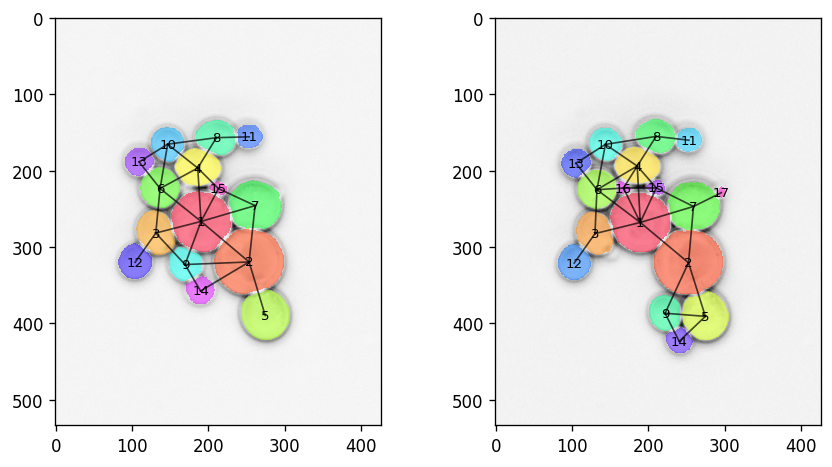

---
timeframe 163
[YeaZ] expected 10->10, got 10->29
[YeaZ] expected 22->22, got 22->10
[YeaZ] expected 25->25, got 25->34
[YeaZ] expected 29->29, got 29->25


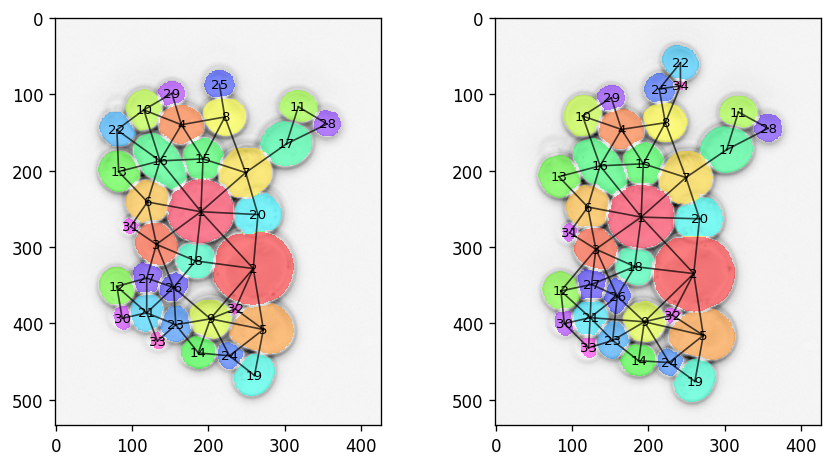

---
timeframe 171
[YeaZ] expected 22->22, got 22->34
[YeaZ] expected 34->34, got 34->22


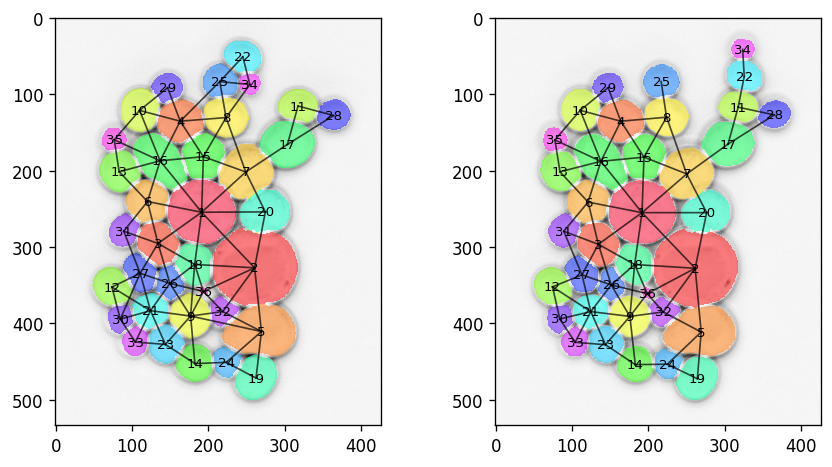

---


In [20]:
for idt in (115, 163, 171):
	print(f'timeframe {idt}')
	
	img_seg1, img_seg2 = imgs_seg[idt], imgs_seg[idt+1]
	cellids1 = bread.utils.get_cellids(img_seg1)
	cellids2 = bread.utils.get_cellids(img_seg2)

	## YeaZ
	
	img_seg2_hat = YeaZ_hung.correspondence(img_seg1, img_seg2)
	idmap2 = match_cellids(img_seg2, img_seg2_hat)

	A = assmatrix_from_segmentations(img_seg1, img_seg2)
	A_hat = assmatrix_from_segmentations(img_seg1, img_seg2)[:, idmap2]
	
	for idx1, (idx2, idx2_hat) in enumerate(zip(np.argmax(A, axis=1), np.argmax(A_hat, axis=1))):
		if idx2 != idx2_hat:
			print(f'[YeaZ] expected {cellids1[idx1]}->{cellids2[idx2]}, got {cellids1[idx1]}->{cellids2[idx2_hat]}')

	graph1, _, df_e1 = bread.data.graph.build_cellgraph(img_seg1, max_membdist=20, return_df=True)
	graph2, _, df_e2 = bread.data.graph.build_cellgraph(img_seg2, max_membdist=20, return_df=True)
	assgraph = bread.data.graph.build_assignmentgraph(graph1, graph2)
	assgraph_truth = bread.data.graph.build_assignmentgraph_track(img_seg1, img_seg2)
	
	z = model(assgraph).detach().reshape(graph1.num_nodes, graph2.num_nodes, 2)
	A_hat = bread_nn.assmatrix_linear_sum(z)
	A = assgraph_truth.x.reshape(graph1.num_nodes, graph2.num_nodes)
	
	for idx1, (idx2, idx2_hat) in enumerate(zip(np.argmax(A, axis=1), np.argmax(A_hat, axis=1))):
		if idx2 != idx2_hat:
			print(f'[bread] expected {cellids1[idx1]}->{cellids2[idx2]}, got {cellids1[idx1]}->{cellids2[idx2_hat]}')
			
	## Plot
			
	fig, ax = plt.subplots(ncols=2, figsize=(8, 4), dpi=120)
	bread.vis.plot_visible(imgs_vis[idt], figax=(fig, ax[0]));
	bread.vis.plot_seg(imgs_seg[idt], figax=(fig, ax[0]), alpha=0.5);
	bread.vis.plot_graph(imgs_seg[idt], df_e1.loc[:, ['cell_id1', 'cell_id2']].to_numpy(), figax=(fig, ax[0]));
	bread.vis.plot_visible(imgs_vis[idt+1], figax=(fig, ax[1]));
	bread.vis.plot_seg(imgs_seg[idt+1], figax=(fig, ax[1]), alpha=0.5);
	bread.vis.plot_graph(imgs_seg[idt+1], df_e2.loc[:, ['cell_id1', 'cell_id2']].to_numpy(), figax=(fig, ax[1]));
	
	plt.show(fig)
	
	print('---')